In [206]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import itertools

In [207]:
class MobilePhone:
    def __init__(self, model, price, antutu_score, dxomark, ppi, battery_capacity):
        self.model = model
        self.price = price
        self.antutu_score = antutu_score
        self.dxomark = dxomark
        self.ppi = ppi
        self.battery_capacity = battery_capacity

    def __str__(self):
        return f"Model: {self.model}, Price ($): {self.price}, Antutu Score: {self.antutu_score}, DXOMARK: {self.dxomark}, PPI: {self.ppi}, Battery Capacity (mAh): {self.battery_capacity}"

    def __eq__(self, other):
        if not isinstance(other, MobilePhone):
            return NotImplemented
        return (self.model == other.model and
                self.price == other.price and
                self.antutu_score == other.antutu_score and
                self.dxomark == other.dxomark and
                self.ppi == other.ppi and
                self.battery_capacity == other.battery_capacity)
    
    def __hash__(self):
        return hash(self.model)


In [208]:
#wczytaj smartfony i utwórz liste z objektami klasy MobilePhone
data = pd.read_csv("smartfony.csv")
phones = []
phones = [MobilePhone(row['Model'], int(row['Cena ($)']), int(row['Antutu Score']), 
          int(row['DXOMARK']), int(row['ppi']), int(row['pojemność baterii (mAh)'])) for index, row in data.iterrows()]



In [209]:
#wyswietl telefony
for phone in phones:
    print(phone)

Model: Huawei Mate 40 Pro, Price ($): 907, Antutu Score: 637017, DXOMARK: 143, PPI: 450, Battery Capacity (mAh): 4360
Model: Google Pixel 7 Pro, Price ($): 899, Antutu Score: 788707, DXOMARK: 147, PPI: 512, Battery Capacity (mAh): 5000
Model: Honor Magic4 Ultimate, Price ($): 1211, Antutu Score: 1051488, DXOMARK: 147, PPI: 460, Battery Capacity (mAh): 4600
Model: Apple iPhone 14 Pro Max, Price ($): 1299, Antutu Score: 960137, DXOMARK: 146, PPI: 460, Battery Capacity (mAh): 4323
Model: Xiaomi 12S Ultra, Price ($): 908, Antutu Score: 1061590, DXOMARK: 136, PPI: 522, Battery Capacity (mAh): 4860
Model: Samsung Galaxy S22 Ultra, Price ($): 1199, Antutu Score: 907693, DXOMARK: 135, PPI: 500, Battery Capacity (mAh): 5000
Model: ROG Phone 6 PRO, Price ($): 999, Antutu Score: 1116637, DXOMARK: 81, PPI: 395, Battery Capacity (mAh): 6000
Model: Motorola Edge 30 Pro, Price ($): 699, Antutu Score: 979697, DXOMARK: 101, PPI: 393, Battery Capacity (mAh): 4800
Model: Galaxy Z Fold4, Price ($): 1799, 

In [210]:
class Criterion:
    def __init__(self, name, type, weight, indiff, pref, veto):
        self.name = name
        self.type = type
        self.weight = weight
        self.indiff = indiff
        self.pref = pref
        self.veto = veto

# Initialize criteria
criteria = [
    Criterion("price", "cost", 2, 50, 200, 600),
    Criterion("antutu", "gain", 4, 100000, 300000, 500000),
    Criterion("dxomark", "gain", 4, 10, 20, 40),
    Criterion("dpi", "gain", 2, 20, 50, 100),
    Criterion("battery", "gain", 3, 400, 1200, 2000)
]

ELECTRE

In [211]:
# Creating the matrix of concordance
concordance = np.ones((len(phones), len(phones)))

# The mapping from phone attributes to the criteria list indices
attribute_mapping = {
    "price": lambda x: x.price,
    "antutu": lambda x: x.antutu_score,
    "dxomark": lambda x: x.dxomark,
    "dpi": lambda x: x.ppi,
    "battery": lambda x: x.battery_capacity
}

for i, phone1 in enumerate(phones):
    for j, phone2 in enumerate(phones):
        cis = []
        dis = []
        for criterion in criteria:
            value1 = attribute_mapping[criterion.name](phone1)
            value2 = attribute_mapping[criterion.name](phone2)
            
            if criterion.type == "gain":
                if value1 - value2 >= -criterion.indiff:
                    cis.append(1)
                elif value1 - value2 < -criterion.pref:
                    cis.append(0)
                else:
                    cis.append((criterion.pref - (value2 - value1)) / (criterion.pref - criterion.indiff))
                
                if value1 - value2 <= -criterion.veto:
                    dis.append(1)
                elif value1 - value2 >= -criterion.pref:
                    dis.append(0)
                else:
                    dis.append(((value2 - value1) - criterion.pref) / (criterion.veto - criterion.pref))

            else:  # Assuming 'cost' type here
                if value1 - value2 <= criterion.indiff:
                    cis.append(1)
                elif value1 - value2 > criterion.pref:
                    cis.append(0)
                else:
                    cis.append((criterion.pref - (value1 - value2)) / (criterion.pref - criterion.indiff))

                if value1 - value2 >= criterion.veto:
                    dis.append(1)
                elif value1 - value2 <= criterion.pref:
                    dis.append(0)
                else:
                    dis.append((criterion.veto - (value1 - value2)) / (criterion.veto - criterion.pref))

        c = sum(ci * criterion.weight for ci, criterion in zip(cis, criteria)) / sum(criterion.weight for criterion in criteria)
        sigma = c

        for d in dis:
            if d > c:
                sigma *= (1 - d) / (1 - c)
        
        concordance[i][j] = round(sigma, 2)

# print(concordance)

In [212]:
def descending_destilation(matrix, variants, upper_threshold=None, depth=0):
    ans = []
    depth += 1

    while True:
        n = matrix.shape[0]
        matrix_copy = deepcopy(matrix)

        if upper_threshold is None:
            mask = np.eye(n, dtype=bool)
            masked_arr = np.ma.masked_array(matrix, mask)
            upper_threshold = np.max(masked_arr)

        if upper_threshold == 0:
            if len(ans) == 1:
                return ans
            else:
                ans.append(deepcopy(variants))
                return ans
            
        if len(variants) == 0:
            return ans
        if len(variants) == 1:
            ans.append(deepcopy(variants))
            return ans
        
        s = -0.15 * upper_threshold + 0.3
        lower_threshold = np.max(matrix[matrix < upper_threshold - s]) if np.any(matrix < upper_threshold - s) else 0

        for i in range(n):
            for j in range(n):
                if matrix[i][j] > lower_threshold and matrix[i][j] > matrix[j][i] + s:
                    continue
                else:
                    matrix_copy[i][j] = 0

        strength = np.array([np.count_nonzero(row) for row in matrix_copy])
        weakness = np.array([np.count_nonzero(column) for column in matrix_copy.T])
        quality = strength - weakness

        if np.count_nonzero(quality == np.max(quality)) == 1:
            max_index = np.argmax(quality)
            ans.append(deepcopy(variants[max_index]))
            variants = variants[:max_index] + variants[max_index+1:]
            matrix = np.delete(matrix, max_index, axis=0)
            matrix = np.delete(matrix, max_index, axis=1)
        else:
            max_indices = np.where(quality == np.max(quality))[0].tolist()
            internal_matrix = deepcopy(matrix_copy[max_indices][:, max_indices])
            internal_variants = [deepcopy(variants[i]) for i in max_indices]

            internal_ans = descending_destilation(internal_matrix, internal_variants, lower_threshold, depth)
            internal_indices = []
            # print("Incomparability!")
            # for phone in itertools.chain.from_iterable(internal_ans):
            #     print(phone)
            for variant in itertools.chain.from_iterable(internal_ans):
                try:
                    internal_indices.append(variants.index(variant))
                except ValueError:
                    continue  # Skip if variant not found

            internal_indices = sorted(internal_indices, reverse=True)
            for internal_index in internal_indices:
                variants.pop(internal_index)

            matrix = np.delete(matrix, np.array(internal_indices), axis=0)
            matrix = np.delete(matrix, np.array(internal_indices), axis=1)

            ans.extend(internal_ans)

        if matrix.shape[0] == 0:
            return ans


variants = deepcopy(phones)

des_dest = descending_destilation(concordance, variants)

In [213]:
def max_element_length(lst):
    max_len = 0
    for item in lst:
        if isinstance(item, list):
            max_len = max(max_len, max_element_length(item))
        else:
            max_len = max(max_len, len(str(item.model)))
    return max_len

print("Descending destilation ranking:")
max_length = max_element_length(des_dest)
for i, row in enumerate(des_dest):
    if type(row) == list:
        for phone in row:
            spacing_model = " " * ((max_length - len(phone.model)) // 2)
            print(spacing_model + phone.model)
    else:
        spacing_model = " " * ((max_length - len(row.model)) // 2)
        print(spacing_model + row.model)
    if(i != len(des_dest) - 1):
        spacing_arrow = " " * ((max_length - 1) // 2)
        print(spacing_arrow + "|")
        print(spacing_arrow + "V")

Descending destilation ranking:
    Xiaomi 12S Ultra
           |
           V
   Google Pixel 7 Pro
           |
           V
       iQOO 9 Pro
           |
           V
     OnePlus 10 Pro
           |
           V
 Honor Magic4 Ultimate
Samsung Galaxy S22 Ultra
           |
           V
      Vivo X80 Pro
     realme GT2 Pro
           |
           V
   Huawei Mate 40 Pro
       Poco F4 GT
           |
           V
    Oppo Find X5 Pro
           |
           V
Apple iPhone 14 Pro Max
    ROG Phone 6 PRO
  Motorola Edge 30 Pro
       Nokia X30
    Redmi K50 Gaming
   ZTE Axon 40 Ultra
           |
           V
    Red Magic 7 Pro
           |
           V
     Galaxy Z Fold4
    Nothing Phone 1


Wstępująca destylacja

In [214]:
#wczytaj smartfony i utwórz liste z objektami klasy MobilePhone
data = pd.read_csv("smartfony.csv")
phones = []
phones = [MobilePhone(row['Model'], int(row['Cena ($)']), int(row['Antutu Score']), 
          int(row['DXOMARK']), int(row['ppi']), int(row['pojemność baterii (mAh)'])) for index, row in data.iterrows()]

In [215]:
# Creating the matrix of concordance
concordance_matrix = np.ones((len(phones), len(phones)))

# The mapping from phone attributes to the criteria list indices
attribute_mapping = {
    "price": lambda x: x.price,
    "antutu": lambda x: x.antutu_score,
    "dxomark": lambda x: x.dxomark,
    "dpi": lambda x: x.ppi,
    "battery": lambda x: x.battery_capacity
}

for i, phone1 in enumerate(phones):
    for j, phone2 in enumerate(phones):
        cis = []
        dis = []
        for criterion in criteria:
            value1 = attribute_mapping[criterion.name](phone1)
            value2 = attribute_mapping[criterion.name](phone2)
            
            if criterion.type == "gain":
                if value1 - value2 >= -criterion.indiff:
                    cis.append(1)
                elif value1 - value2 < -criterion.pref:
                    cis.append(0)
                else:
                    cis.append((criterion.pref - (value2 - value1)) / (criterion.pref - criterion.indiff))
                
                if value1 - value2 <= -criterion.veto:
                    dis.append(1)
                elif value1 - value2 >= -criterion.pref:
                    dis.append(0)
                else:
                    dis.append(((value2 - value1) - criterion.pref) / (criterion.veto - criterion.pref))

            else:  # Assuming 'cost' type here
                if value1 - value2 <= criterion.indiff:
                    cis.append(1)
                elif value1 - value2 > criterion.pref:
                    cis.append(0)
                else:
                    cis.append((criterion.pref - (value1 - value2)) / (criterion.pref - criterion.indiff))

                if value1 - value2 >= criterion.veto:
                    dis.append(1)
                elif value1 - value2 <= criterion.pref:
                    dis.append(0)
                else:
                    dis.append((criterion.veto - (value1 - value2)) / (criterion.veto - criterion.pref))

        c = sum(ci * criterion.weight for ci, criterion in zip(cis, criteria)) / sum(criterion.weight for criterion in criteria)
        sigma = c

        for d in dis:
            if d > c:
                if c == 1:
                    print("c = 1")
                sigma *= (1 - d) / (1 - c)
        
        concordance_matrix[i][j] = round(sigma, 2)

# print(concordance_matrix)

In [216]:
def ascending_destilation(matrix, variants, upper_threshold=None, depth=0):
    ans = []
    depth += 1

    while True:
        n = matrix.shape[0]
        matrix_copy = deepcopy(matrix)

        if upper_threshold is None:
            mask = np.eye(n, dtype=bool)
            masked_arr = np.ma.masked_array(matrix, mask)
            upper_threshold = np.max(masked_arr)

        if upper_threshold == 0:
            if len(ans) == 1:
                return ans
            else:
                ans.append(deepcopy(variants))
                return ans
            
        if len(variants) == 0:
            return ans
        if len(variants) == 1:
            ans.append(deepcopy(variants))
            return ans
        
        s = -0.15 * upper_threshold + 0.3
        lower_threshold = np.max(matrix[matrix < upper_threshold - s]) if np.any(matrix < upper_threshold - s) else 0

        for i in range(n):
            for j in range(n):
                if matrix[i][j] > lower_threshold and matrix[i][j] > matrix[j][i] + s:
                    continue
                else:
                    matrix_copy[i][j] = 0

        strength = np.array([np.count_nonzero(row) for row in matrix_copy])
        weakness = np.array([np.count_nonzero(column) for column in matrix_copy.T])
        quality = strength - weakness

        if np.count_nonzero(quality == np.min(quality)) == 1:
            min_index = np.argmin(quality)
            ans.insert(0, deepcopy(variants[min_index]))
            variants = variants[:min_index] + variants[min_index+1:]
            matrix = np.delete(matrix, min_index, axis=0)
            matrix = np.delete(matrix, min_index, axis=1)
        else:
            min_indices = np.where(quality == np.min(quality))[0].tolist()
            internal_matrix = deepcopy(matrix_copy[min_indices][:, min_indices])
            internal_variants = [deepcopy(variants[i]) for i in min_indices]

            internal_ans = ascending_destilation(internal_matrix, internal_variants, lower_threshold, depth)
            internal_indices = []
            # print("Incomparability!")
            # for phone in internal_ans:
                # print(phone)
            for variant in itertools.chain.from_iterable(internal_ans):
                try:
                    internal_indices.insert(0,variants.index(variant))
                except ValueError:
                    continue  # Skip if variant not found

            internal_indices = sorted(internal_indices, reverse=True)
            for internal_index in internal_indices:
                variants.pop(internal_index)

            matrix = np.delete(matrix, np.array(internal_indices), axis=0)
            matrix = np.delete(matrix, np.array(internal_indices), axis=1)

            ans[0:0] = internal_ans 

        if matrix.shape[0] == 0:
            return ans


variants = deepcopy(phones)

asc_dest = ascending_destilation(concordance_matrix, variants)

In [217]:
print("Ascending destilation ranking:")
max_length = max_element_length(asc_dest)
for i, row in enumerate(asc_dest):
    if type(row) == list:
        for phone in row:
            spacing_model = " " * ((max_length - len(phone.model)) // 2)
            print(spacing_model + phone.model)
    else:
        spacing_model = " " * ((max_length - len(row.model)) // 2)
        print(spacing_model + row.model)
    if(i != len(asc_dest) - 1):
        spacing_arrow = " " * ((max_length - 1) // 2)
        print(spacing_arrow + "|")
        print(spacing_arrow + "V")

Ascending destilation ranking:
    Xiaomi 12S Ultra
    ROG Phone 6 PRO
      Vivo X80 Pro
           |
           V
   Google Pixel 7 Pro
           |
           V
 Honor Magic4 Ultimate
       iQOO 9 Pro
           |
           V
Samsung Galaxy S22 Ultra
     OnePlus 10 Pro
     realme GT2 Pro
           |
           V
Apple iPhone 14 Pro Max
    Oppo Find X5 Pro
           |
           V
   Huawei Mate 40 Pro
       Poco F4 GT
           |
           V
       Nokia X30
    Redmi K50 Gaming
           |
           V
  Motorola Edge 30 Pro
           |
           V
    Red Magic 7 Pro
           |
           V
     Galaxy Z Fold4
   ZTE Axon 40 Ultra
           |
           V
    Nothing Phone 1


# Ranking kompletny dla Electre

In [218]:
# Helper function to create matrices
def initialize_matrix(size, value=0):
    return np.full((size, size), value)

def find_rank(phone, rankings):
    """ Find the rank level of the given phone in the possibly nested ranking list. """
    for i, rank in enumerate(rankings):
        if isinstance(rank, list):  # Handling a list of phones at the same rank
            if any(phone.model == p.model for p in rank):
                return i
        elif phone.model == rank.model:  # Handling a single phone at a rank
            return i
    return None  # Not found

def compare_ranks(phone1, phone2, rankings):
    rank1 = find_rank(phone1, rankings)
    rank2 = find_rank(phone2, rankings)

    if rank1 is None or rank2 is None:
        return None  # If either item is not in the rankings
    if rank1 < rank2:
        return 'preferred'  # phone1 is preferred over phone2
    elif rank1 > rank2:
        return 'less_preferred'  # phone1 is less preferred than phone2
    return 'equal'  # phones are ranked equally


def calculate_matrices_with_ranking(phones, asc_dest, des_dest):
    n = len(phones)
    P_matrix = initialize_matrix(n, False)
    I_matrix = initialize_matrix(n, False)
    R_matrix = initialize_matrix(n, False)

    for i, phone1 in enumerate(phones):
        for j, phone2 in enumerate(phones):
            if i == j:
                I_matrix[i][j] = True  # Every item is indifferent to itself
                continue

            rank_asc = compare_ranks(phone1, phone2, asc_dest)
            rank_des = compare_ranks(phone1, phone2, des_dest)

            if (rank_asc == 'preferred' and (rank_des == 'preferred' or rank_des == 'equal')) or \
               (rank_des == 'preferred' and (rank_asc == 'preferred' or rank_asc == 'equal')):
                P_matrix[i][j] = True
            elif rank_asc == 'equal' and rank_des == 'equal':
                I_matrix[i][j] = True
            else:
                R_matrix[i][j] = True

    return P_matrix, I_matrix, R_matrix



P_matrix, I_matrix, R_matrix = calculate_matrices_with_ranking(phones, asc_dest, des_dest)

print("Preference Matrix (P):")
print(P_matrix)
print("Indifference Matrix (I):")
print(I_matrix)
print("Incomparability Matrix (R):")
print(R_matrix)


Preference Matrix (P):
[[False False False False False False False  True  True False False False
   True  True  True False  True False False  True]
 [ True False  True  True False  True False  True  True False  True  True
   True  True  True  True  True  True  True  True]
 [ True False False  True False  True False  True  True False  True False
   True  True  True  True  True  True False  True]
 [False False False False False False False  True  True False False False
   True  True  True False  True False False  True]
 [ True  True  True  True False  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True False False  True False False False  True  True False  True False
   True  True  True  True  True  True False  True]
 [False False False  True False False False  True  True False False False
   True  True  True False  True False False  True]
 [False False False False False False False False  True False False False
   True False  True False Fa

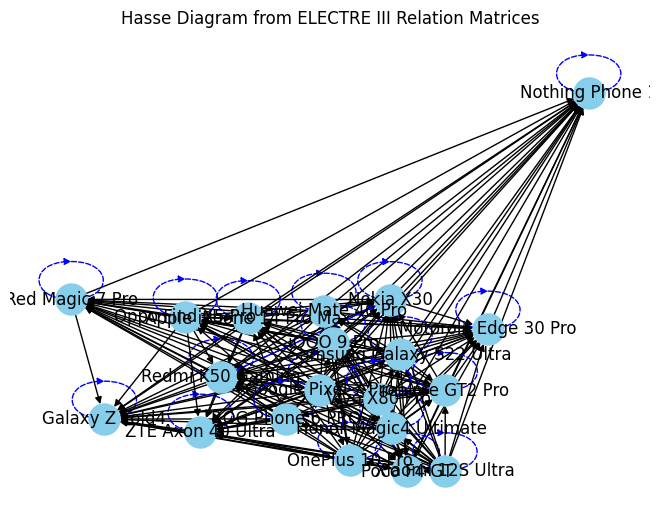

In [219]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_electre_hasse_diagram(phones, P_matrix, I_matrix, R_matrix):
    G = nx.DiGraph()
    phone_to_index = {phone.model: i for i, phone in enumerate(phones)}
    index_to_phone = {i: phone for i, phone in enumerate(phones)}

    # Add edges based on direct preferences, indifference, and incomparability
    for i in range(len(phones)):
        for j in range(len(phones)):
            if P_matrix[i][j]:
                G.add_edge(index_to_phone[i].model, index_to_phone[j].model, color='black')  # Preference
            if I_matrix[i][j]:
                G.add_edge(index_to_phone[i].model, index_to_phone[j].model, color='blue', style='dashed')  # Indifference
            if R_matrix[i][j]:
                G.add_edge(index_to_phone[i].model, index_to_phone[j].model, color='red', style='dotted')  # Incomparability

    # Determine node positions based on layers or ranks
    pos = nx.spring_layout(G, seed=42)  # or use other layout that reflects the importance

    # Draw the graph, applying style distinctions for different edge types
    edges = G.edges(data=True)
    colors = [edge[2]['color'] for edge in edges]
    styles = [edge[2].get('style', 'solid') for edge in edges]
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=12, edge_color=colors, style=styles)
    plt.title('Hasse Diagram from ELECTRE III Relation Matrices')
    plt.axis('off')  # Turn off the axis to improve clarity
    plt.show()

# Assuming matrices are correctly set up
draw_electre_hasse_diagram(phones, P_matrix, I_matrix, R_matrix)


PROMETHEE

In [220]:
preference_matrix = np.zeros((len(phones), len(phones)))

for i, phone1 in enumerate(phones):
    for j, phone2 in enumerate(phones):
        pis = []
        for criterion in criteria:
            value1 = attribute_mapping[criterion.name](phone1)
            value2 = attribute_mapping[criterion.name](phone2)
            
            if criterion.type == "gain":
                if value1 - value2 >= criterion.pref:
                    pis.append(1)
                elif value1 - value2 <= criterion.indiff:
                    pis.append(0)
                else:
                    pis.append((value1 - value2 - criterion.indiff) / (criterion.pref - criterion.indiff))
            
            else:
                if value2 - value1 >= criterion.pref:
                    pis.append(1)
                elif value2 - value1 <= criterion.indiff:
                    pis.append(0)
                else:
                    pis.append((value2 - value1 - criterion.indiff) / (criterion.pref - criterion.indiff))
                    
        pi = sum(pi * criterion.weight for pi, criterion in zip(pis, criteria)) / sum(criterion.weight for criterion in criteria)

        preference_matrix[i][j] = round(pi, 2)

# print(preference_matrix)

In [221]:
positive_flow = np.sum(preference_matrix, axis=1).tolist()
negative_flow = np.sum(preference_matrix, axis=0).tolist()
net_flow = (np.array(positive_flow) - np.array(negative_flow)).tolist()

PROMETHEE I

In [222]:
variants = deepcopy(phones)

combined = list(zip(positive_flow, variants))
combined.sort(key=lambda x: x[0], reverse=True)

positive_ranking = [item[1] for item in combined]

print("Ranking based on positive flow:")
max_length = max_element_length(positive_ranking)
for i, phone in enumerate(positive_ranking):
    spacing_model = " " * ((max_length - len(phone.model)) // 2)
    print(spacing_model + phone.model)
    if(i != len(positive_ranking) - 1):
        spacing_arrow = " " * ((max_length - 1) // 2)
        print(spacing_arrow + "|")
        print(spacing_arrow + "V")
print()

combined = list(zip(negative_flow, variants))
combined.sort(key=lambda x: x[0])

negative_ranking = [item[1] for item in combined]

print("Ranking based on negatiev flow:")
max_length = max_element_length(negative_ranking)
for i, phone in enumerate(negative_ranking):
    spacing_model = " " * ((max_length - len(phone.model)) // 2)
    print(spacing_model + phone.model)
    if(i != len(negative_ranking) - 1):
        spacing_arrow = " " * ((max_length - 1) // 2)
        print(spacing_arrow + "|")
        print(spacing_arrow + "V")
print()

# combined_ranking = []
# for phone in variants:
#     i = 0
#     if len(combined_ranking) == 0:
#         combined_ranking.append([phone])
#     for phone2 in itertools.chain.from_iterable(combined_ranking):
#         i += 1
#         if phone.model == phone2[1].model:
#             combined_ranking.append(phone2[1])
    


Ranking based on positive flow:
    ROG Phone 6 PRO
           |
           V
   Google Pixel 7 Pro
           |
           V
 Honor Magic4 Ultimate
           |
           V
    Xiaomi 12S Ultra
           |
           V
Apple iPhone 14 Pro Max
           |
           V
       iQOO 9 Pro
           |
           V
     realme GT2 Pro
           |
           V
     OnePlus 10 Pro
           |
           V
      Vivo X80 Pro
           |
           V
   Huawei Mate 40 Pro
           |
           V
Samsung Galaxy S22 Ultra
           |
           V
    Oppo Find X5 Pro
           |
           V
       Poco F4 GT
           |
           V
       Nokia X30
           |
           V
   ZTE Axon 40 Ultra
           |
           V
  Motorola Edge 30 Pro
           |
           V
    Redmi K50 Gaming
           |
           V
    Red Magic 7 Pro
           |
           V
     Galaxy Z Fold4
           |
           V
    Nothing Phone 1

Ranking based on negatiev flow:
    Xiaomi 12S Ultra
     

In [223]:
def determine_relations(positive_flow, negative_flow):
    num_phones = len(positive_flow)
    P_matrix = np.zeros((num_phones, num_phones), dtype=int)
    I_matrix = np.zeros((num_phones, num_phones), dtype=int)
    R_matrix = np.zeros((num_phones, num_phones), dtype=int)

    for i in range(num_phones):
        for j in range(num_phones):
            if i == j:
                I_matrix[i][j] = 1  # A phone is always indifferent to itself
            else:
                # Determine Preference (P)
                better_strength = positive_flow[i] > positive_flow[j]
                equal_strength = positive_flow[i] == positive_flow[j]
                better_weakness = negative_flow[i] < negative_flow[j]
                equal_weakness = negative_flow[i] == negative_flow[j]

                if (better_strength and (equal_weakness or better_weakness)) or (better_weakness and (equal_strength or better_strength)):
                    P_matrix[i][j] = 1
                elif equal_strength and equal_weakness:
                    I_matrix[i][j] = 1
                else:
                    R_matrix[i][j] = 1

    return P_matrix, I_matrix, R_matrix

P_matrix, I_matrix, R_matrix = determine_relations(positive_flow, negative_flow)

print("Preference Matrix (P):\n", P_matrix)
print("Indifference Matrix (I):\n", I_matrix)
print("Incomparability Matrix (R):\n", R_matrix)

Preference Matrix (P):
 [[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1]
 [1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1]
 [1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1]
 [1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1]
 [0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1]
 [1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]]
Indifference Matrix (I):
 [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0

PROMETHEE II

In [224]:
variants = deepcopy(phones)

combined = list(zip(net_flow, variants))
combined.sort(key=lambda x: x[0], reverse=True)

ranking = [item[1] for item in combined]

print("Ranking based on a net flow:")
max_length = max(len(phone.model) for phone in ranking)
for i, phone in enumerate(ranking):
    spacing_model = " " * ((max_length - len(phone.model)) // 2)
    print(spacing_model + phone.model)
    if(i != len(ranking) - 1):
        spacing_arrow = " " * ((max_length - 1) // 2)
        print(spacing_arrow + "|")
        print(spacing_arrow + "V")

Ranking based on a net flow:
    Xiaomi 12S Ultra
           |
           V
   Google Pixel 7 Pro
           |
           V
 Honor Magic4 Ultimate
           |
           V
       iQOO 9 Pro
           |
           V
      Vivo X80 Pro
           |
           V
Samsung Galaxy S22 Ultra
           |
           V
     OnePlus 10 Pro
           |
           V
Apple iPhone 14 Pro Max
           |
           V
    Oppo Find X5 Pro
           |
           V
     realme GT2 Pro
           |
           V
    ROG Phone 6 PRO
           |
           V
       Poco F4 GT
           |
           V
   Huawei Mate 40 Pro
           |
           V
  Motorola Edge 30 Pro
           |
           V
   ZTE Axon 40 Ultra
           |
           V
    Redmi K50 Gaming
           |
           V
     Galaxy Z Fold4
           |
           V
    Red Magic 7 Pro
           |
           V
       Nokia X30
           |
           V
    Nothing Phone 1


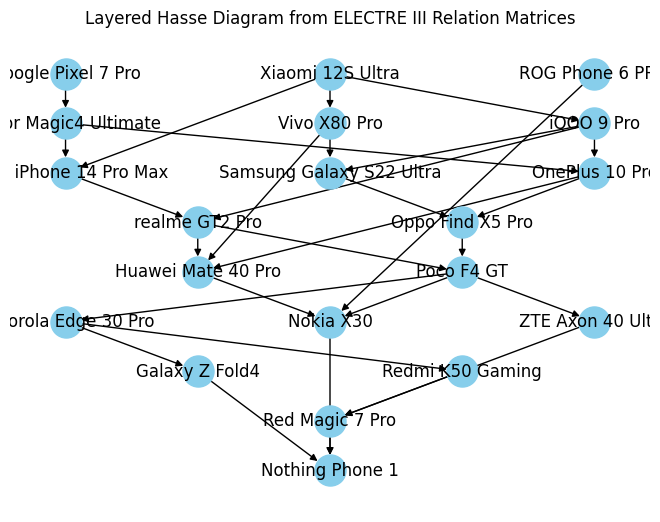

In [226]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_electre_hasse_diagram(phones, P_matrix, I_matrix):
    G = nx.DiGraph()
    phone_to_index = {phone.model: i for i, phone in enumerate(phones)}
    index_to_phone = {i: phone for i, phone in enumerate(phones)}

    # Count incoming preference edges for each phone
    incoming_edges = [0] * len(phones)
    for i in range(len(phones)):
        for j in range(len(phones)):
            if P_matrix[i][j]:
                incoming_edges[j] += 1

    # Determine layers by processing levels of incoming edge counts
    layers = []
    process_queue = [i for i in range(len(phones)) if incoming_edges[i] == 0]  # Start with zero incoming edges
    next_queue = []

    while process_queue:
        layers.append(process_queue)
        for i in process_queue:
            for j in range(len(phones)):
                if P_matrix[i][j]:
                    incoming_edges[j] -= 1
                    if incoming_edges[j] == 0:
                        next_queue.append(j)
        process_queue, next_queue = next_queue, []

    # Add edges to graph based on direct preferences and indifference
    for i in range(len(phones)):
        for j in range(len(phones)):
            if P_matrix[i][j]:
                G.add_edge(index_to_phone[i].model, index_to_phone[j].model, color='black')
            elif I_matrix[i][j]:
                # If indifferent, group nodes together visually by placing them at the same y-level
                # We will find the highest layer containing either and place both there
                i_layer = next((l for l, layer in enumerate(layers) if i in layer), None)
                j_layer = next((l for l, layer in enumerate(layers) if j in layer), None)
                if i_layer is not None and j_layer is not None:
                    if i_layer != j_layer:
                        # Move the lower node to the higher node's layer
                        higher_layer = min(i_layer, j_layer)
                        layers[higher_layer].extend(layers[max(i_layer, j_layer)])
                        layers[max(i_layer, j_layer)] = []

    # Set node positions manually to visualize layers
    pos = {}
    for layer_index, layer in enumerate(layers):
        x_offsets = range(len(layer))
        for i, x_offset in zip(layer, x_offsets):
            pos[index_to_phone[i].model] = (x_offset - len(layer) / 2, -layer_index)

    # Perform transitive reduction to remove redundant edges
    TR = nx.transitive_reduction(G)

    # Draw the graph with transitive reduction applied
    edges = TR.edges(data=True)
    colors = [edge[2].get('color', 'black') for edge in edges]
    nx.draw(TR, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=12, edge_color=colors)
    plt.title('Layered Hasse Diagram from ELECTRE III Relation Matrices')
    plt.axis('off')  # Turn off the axis to improve clarity
    plt.show()

# Assuming you have your phones list and P_matrix and I_matrix correctly set up
draw_electre_hasse_diagram(phones, P_matrix, I_matrix)
